# here is an exalmple of a poly blep class

In [3]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

In [122]:
#first a class to form a naive wave
class waveGen:
    
    def __init__(self, freq, BufferSize, waveType, vol):
        
        self.sampleRate = 48000
        self.bufferSize = BufferSize
        self.buffer = np.empty(BufferSize, dtype=np.complex)
        self.frequency = freq
        self.omega = 0
        self.updateOmega()
        self.last = complex(1,0)
        self.type = waveType
        self.volume = vol
        self.sawLast = 0
        

    def sineGen(self):

        #start = timer() #reduce function!!! functools
        for i in range(0, self.bufferSize):
            self.buffer[i] = self.last
            self.last=self.last*self.omega

        return self.volume * np.imag(self.buffer).astype(np.float32)

    def squareGen(self):
        #start = timer()
        for i in range(0, self.bufferSize):
            self.buffer[i] = self.last
            self.last=self.last*self.omega

        return np.sign(self.volume * np.imag(self.buffer).astype(np.float64))
    
    def sawGen(self):
        wav_len = self.sampleRate / self.frequency
        half_wave_len = wav_len / 2
        
        for i in range(0, self.bufferSize):
            pos = (i + self.sawLast) % wav_len
            self.buffer[i] = ((pos / half_wave_len) - 1) * self.volume
        
        self.sawLast = (self.bufferSize + self.sawLast) % wav_len
        
        return self.buffer.astype(np.float32)
    
    def triangleGen(self):
        wav_len = self.sampleRate / self.frequency
        half_wave_len = wav_len / 2
        
        for i in range(self.bufferSize):
            self.buffer[i] = ( 2 * abs((((i + self.sawLast) % wav_len) / half_wave_len) - 1) - 1) * self.volume * -1
        
        return self.buffer.astype(np.float32)

    def updateOmega(self):
        self.omega = cmath.exp(1j*(2*cmath.pi * self.frequency / self.sampleRate))

    def updateFreq(self, val):
        self.frequency = val
        self.updateOmega()

    def nextFrame(self):
        if self.type == "sine":
            return self.sineGen()
        elif self.type == "square":
            return self.squareGen()
        elif self.type == "triangle":
            return self.triangleGen()
        elif self.type == "saw":
            return self.sawGen()

In [155]:
#poli-Blep class
class polyBlep:

    def __init__(self, Sample_Rate = 48000):
        
        self.twoPI = np.pi * 2 # times 3 seems go give the best result around to 
        self.freq = 0
        self.sample_rate = Sample_Rate
        self.mPhaseIncrement = 0
        self.mPhase = 0
        self.FP_Correction = 0.9999999 # this is currently only guess at a good value, 
                                                 # it is also not a catch all value
        
    def runFrame(self, naive, Freq, waveType):
        
        self.freq = Freq
        self.mPhaseIncrement = self.freq * self.twoPI / self.sample_rate
        output = np.empty(len(naive))
        if waveType == 'square':
            for i in range(len(naive)):
                output[i] = self.nextSample_square(naive[i])
        
        elif waveType == 'saw':
            for i in range(len(naive)):
                output[i] = self.nextSample_saw(naive[i])
        
        elif waveType == 'tri':
            for i in range(len(naive)):
                output[i] = self.nextSample_tri(naive[i])
        
        return output
        
    def nextSample_square(self, sample):
        
        t = self.mPhase / self.twoPI
        sample += self.poly_blep(t)
        sample -= self.poly_blep((t + 0.5) % 1)
        
        self.mPhase += self.mPhaseIncrement #* self.FP_Correction
        
        while self.mPhase > self.twoPI:
            self.mPhase -= self.twoPI
            self.mPhase = round(self.mPhase, 5)
        
        return sample
    
    
    def nextSample_saw(self, sample):
        t = self.mPhase / self.twoPI
        sample -= self.poly_blep(t)
        
        self.mPhase += self.mPhaseIncrement * self.FP_Correction
            
        while self.mPhase > self.twoPI:
            self.mPhase -= self.twoPI
        
        return sample
    
    def nextSample_tri(self, sample): #this not working
        t = self.mPhase / self.twoPI / 2
        #sample += self.poly_blep(t)
        sample -= self.poly_blep((t + 0.5) % 1)
        
        self.mPhase += self.mPhaseIncrement * self.FP_Correction
            
        while self.mPhase > self.twoPI / 2:
            self.mPhase -= self.twoPI / 2

            
        
        return sample
    
    
    def poly_blep(self, t):
        dt = self.mPhaseIncrement / (np.pi * 2)
        # 0 <= t < 1
        if t < dt: 
            t /= dt;
            return t+t - t*t - 1.0;
    
        # -1 < t < 0
        elif t > 1.0 - dt: 
            t = (t - 1.0) / dt
            return t*t + t+t + 1.0
        
        # 0 otherwise
        else:
            return 0.0;

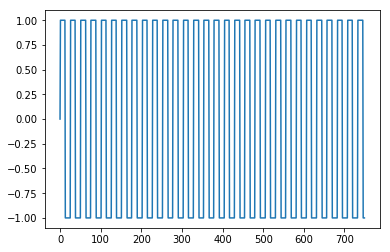

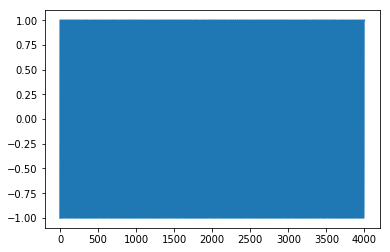

In [160]:
freq = 1900
sample_rate = 48000
length = 48000

wave = waveGen(freq, length, 'square', 1)
poly = polyBlep()

naive_wave = wave.nextFrame()

plt.plot(naive_wave[:750])
plt.show()

output = poly.runFrame(naive_wave, freq, 'square')



plt.plot(output[:4000])
plt.show()



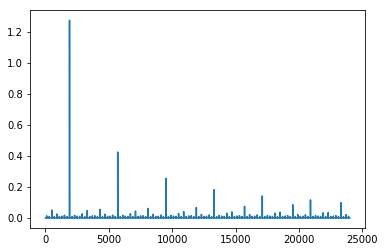

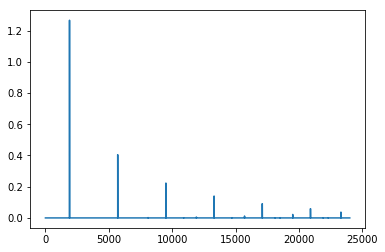

In [161]:
t_dom = np.fft.fft(output)
n_t_dom = np.fft.fft(naive_wave)
#linespaceing
T = 1.0 / 48000.0

#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), sample_rate//2)

#ploting the graph
plt.plot(xf, 2.0/sample_rate * np.abs(n_t_dom[:sample_rate//2]))
plt.show()


plt.plot(xf, 2.0/sample_rate * np.abs(t_dom[:sample_rate//2]))
plt.show()

In [158]:
for i in range(0, 7000, 100):
    
    wave = waveGen(i, length, 'square', 1)
    poly = polyBlep()
    naive_wave = wave.nextFrame()
    output = poly.runFrame(naive_wave, i, 'square')
    
    if not np.all(output < 1.5):
        print(i)

200
700
800
900
1000
1200
1300
1400
1500
1600
1700
1800
2000
2300
2400
2500
2600
2800
2900
3100
3200
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4900
5100
5200
5500
5600
5700
5800
5900
6000
6100
6200
6300
6800


# The remaining issue here is in the inacuracy of floating point intergers, 
## the current correnction technique can only work between a sqecific frequency band

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


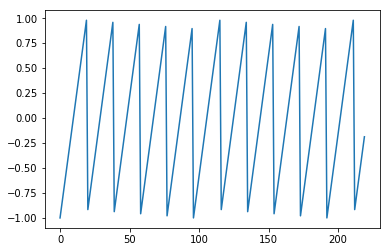

In [101]:
wave = waveGen(freq, length, 'saw', 1)
saw = wave.nextFrame()
plt.plot(saw[:220])
plt.show()

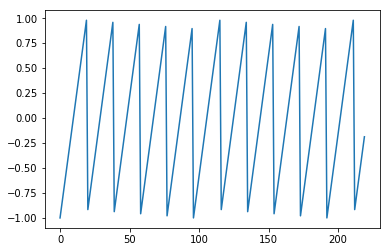

In [102]:
output = poly.runFrame(saw, freq, 'saw')

plt.plot(output[:220])
plt.show()

In [103]:
# Triangle

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part


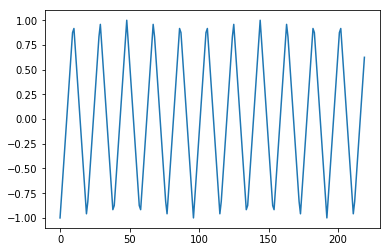

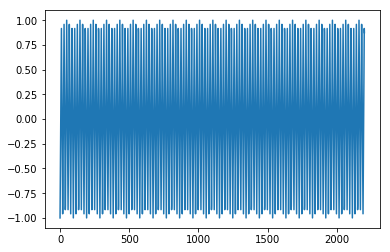

In [104]:
wave = waveGen(freq, length, 'triangle', 1)
tri = wave.nextFrame()
plt.plot(tri[:220])
plt.show()

output = poly.runFrame(tri, freq, 'tri')

plt.plot(output[:2200])
plt.show()

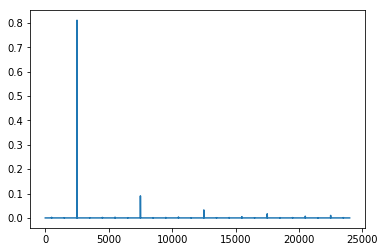

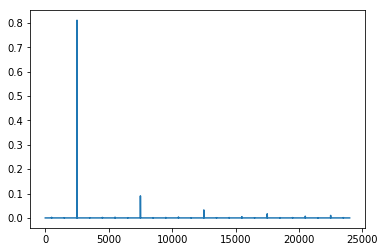

In [105]:
t_dom = np.fft.fft(output)
n_t_dom = np.fft.fft(tri)
#linespaceing
T = 1.0 / 48000.0

#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), sample_rate//2)

#ploting the graph
plt.plot(xf, 2.0/sample_rate * np.abs(n_t_dom[:sample_rate//2]))
plt.show()


plt.plot(xf, 2.0/sample_rate * np.abs(t_dom[:sample_rate//2]))
plt.show()